## Desafío - Árboles de Regresión
* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la seccióncorrespondiente.

### Descripción
* Para esta sesión trabajaremos con una base de datos sobre los precios de inmuebles en la ciudad de Ames, Iowa. La base se compone de 2930 registros y contiene un gran número de atributos.
* Nuestro objetivo es generar un modelo que prediga de forma adecuada los precios de inmuebles, medidos con la variable Sale_Price.


Nombres: María Eugenia Valenzuela - Rene Navarro - Juan Oyarce

#### Ejercicio 1: Preparación del ambiente de trabajo
* Importe las librerías clásicas a utilizar.
* Para este ejercicio implementaremos árboles de regresión, por lo que deberá importar la clase DecisionTreeRegressor.
* De manera adicional importe las funciones y clases necesarias para generar un desempeño de métricas en problemas de regresión, división de muestras y búsqueda de grilla con validación cruzada.
* Elimine la columna 'Unnamed: 0' cuando cargue los datos.

In [65]:
# Importación de librerías
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lec7_graphs as afx
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score
import pickle 

import operator
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
 
 

In [3]:
df = pd.read_csv('ames_housing.csv').drop(columns='Unnamed: 0')
df.head()

,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.638933,42.060899


In [4]:
df.shape

(2930, 81)

#### Ejercicio 2: Feature engineering
* Identifique si el dtype de cada pd.Serie en nuestra base de datos se considera 'object' o no. Para todas las variables que sean 'object', realice lo siguiente:
    1. Genere una recodificación $K-1$ en cada variable. Para efectos prácticos sólo necesitan eliminar una de las categorías, no se concentren en especificar la categoría a eliminar. Pueden utilizar la función pd.get_dummies con la opción drop_first para ello.
    2. Utilizando el método pd.concat , concatene a los atributos creados en la base de datos. 


In [49]:
#generación de dummies
dummies=[]
for i in df.columns:
    if df[i].dtypes == 'object':
        dummies.append(i)
for i in dummies:
    df = pd.concat([df, pd.get_dummies(df[i], drop_first=True, prefix=i+'_')], axis=1)
    df.drop(i, axis = 1, inplace = True)


In [47]:
df.shape

(2930, 307)

In [48]:
df.head(5)

,Lot_Frontage,Lot_Area,Year_Built,Year_Remod_Add,Mas_Vnr_Area,BsmtFin_SF_1,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,First_Flr_SF,...,Sale_Type__ConLw,Sale_Type__New,Sale_Type__Oth,Sale_Type__VWD,Sale_Type__WD,Sale_Condition__AdjLand,Sale_Condition__Alloca,Sale_Condition__Family,Sale_Condition__Normal,Sale_Condition__Partial
0,141,31770,1960,1960,112,2,0,441,1080,1656,...,0,0,0,0,1,0,0,0,1,0
1,80,11622,1961,1961,0,6,144,270,882,896,...,0,0,0,0,1,0,0,0,1,0
2,81,14267,1958,1958,108,1,0,406,1329,1329,...,0,0,0,0,1,0,0,0,1,0
3,93,11160,1968,1968,0,1,0,1045,2110,2110,...,0,0,0,0,1,0,0,0,1,0
4,74,13830,1997,1998,0,3,0,137,928,928,...,0,0,0,0,1,0,0,0,1,0


#### Ejercicio 3: Primer modelo
* Genere muestras de entrenamiento y validación con 'Sale_Price' como vector objetivo y los atributos de la base de datos como matriz.
* Recuerde definir el porcentaje de casos en la muestra de validación y una semilla pseudoaleatoria.
* Posteriormente, entrene un árbol de regresión en la muestra de entrenamiento sin modificar los hiperparámetros. Reporte las principales métricas de desempeño.
* Comente sobre el desempeño.

In [62]:
# Nos aseguramos de limpiar los datos perdidos
df = df.dropna()


In [51]:
#Conjunto de variables
variables= list(df.columns)
variables.remove('Sale_Price')


In [59]:
# generamos las muestras definiendo la matriz de atributos
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,variables],
# el vector objetivo
df['Sale_Price'],
# el tamaño de la muestra  a dejar como validación
test_size=.33,
# definiendo la semillapseudoaleatoria
random_state=1986)

In [14]:
#Modelo original del árbol de regresión 
reg_tree = DecisionTreeRegressor().fit(X_train, y_train)


In [15]:
#Metricas para evaluar el modelo
print("Test MSE:", mean_squared_error(y_test, reg_tree.predict(X_test)).round(5))
print("Test MAE:", median_absolute_error(y_test, reg_tree.predict(X_test)).round(5))
print("Test R2:", r2_score(y_test, reg_tree.predict(X_test)).round(5))

Test MSE: 1473771387.88314
Test MAE: 15000.0
Test R2: 0.77754


- Se puede apreciar un error MAE cercano a 15000 y un valor de r2 cercano a 0.78, lo que indica que el modelo explica el 78% de la varianza, siendo un buen modelo

#### Ejercicio 4: Importancia relativa
* Implemente el método plot_importance utilizado en la lectura para reportar la importancia relativa de los atributos.
* Comente sobre cuáles son los principales 10 atributos que afectan la predicción de Sale_Price.
* Separe éstos 10 atributos en una nueva base de datos, junto con el vector objetivo.

In [52]:
#Función para graficar la importancia de los atributos
def plot_importance(fit_model, feat_names):
    """TODO: Docstring for plot_importance.

    :fit_model: TODO
    :: TODO
    :returns: TODO

    """
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(len(feat_names)), tmp_importance[sort_importance])
    plt.yticks(range(len(feat_names)), names, rotation=0)

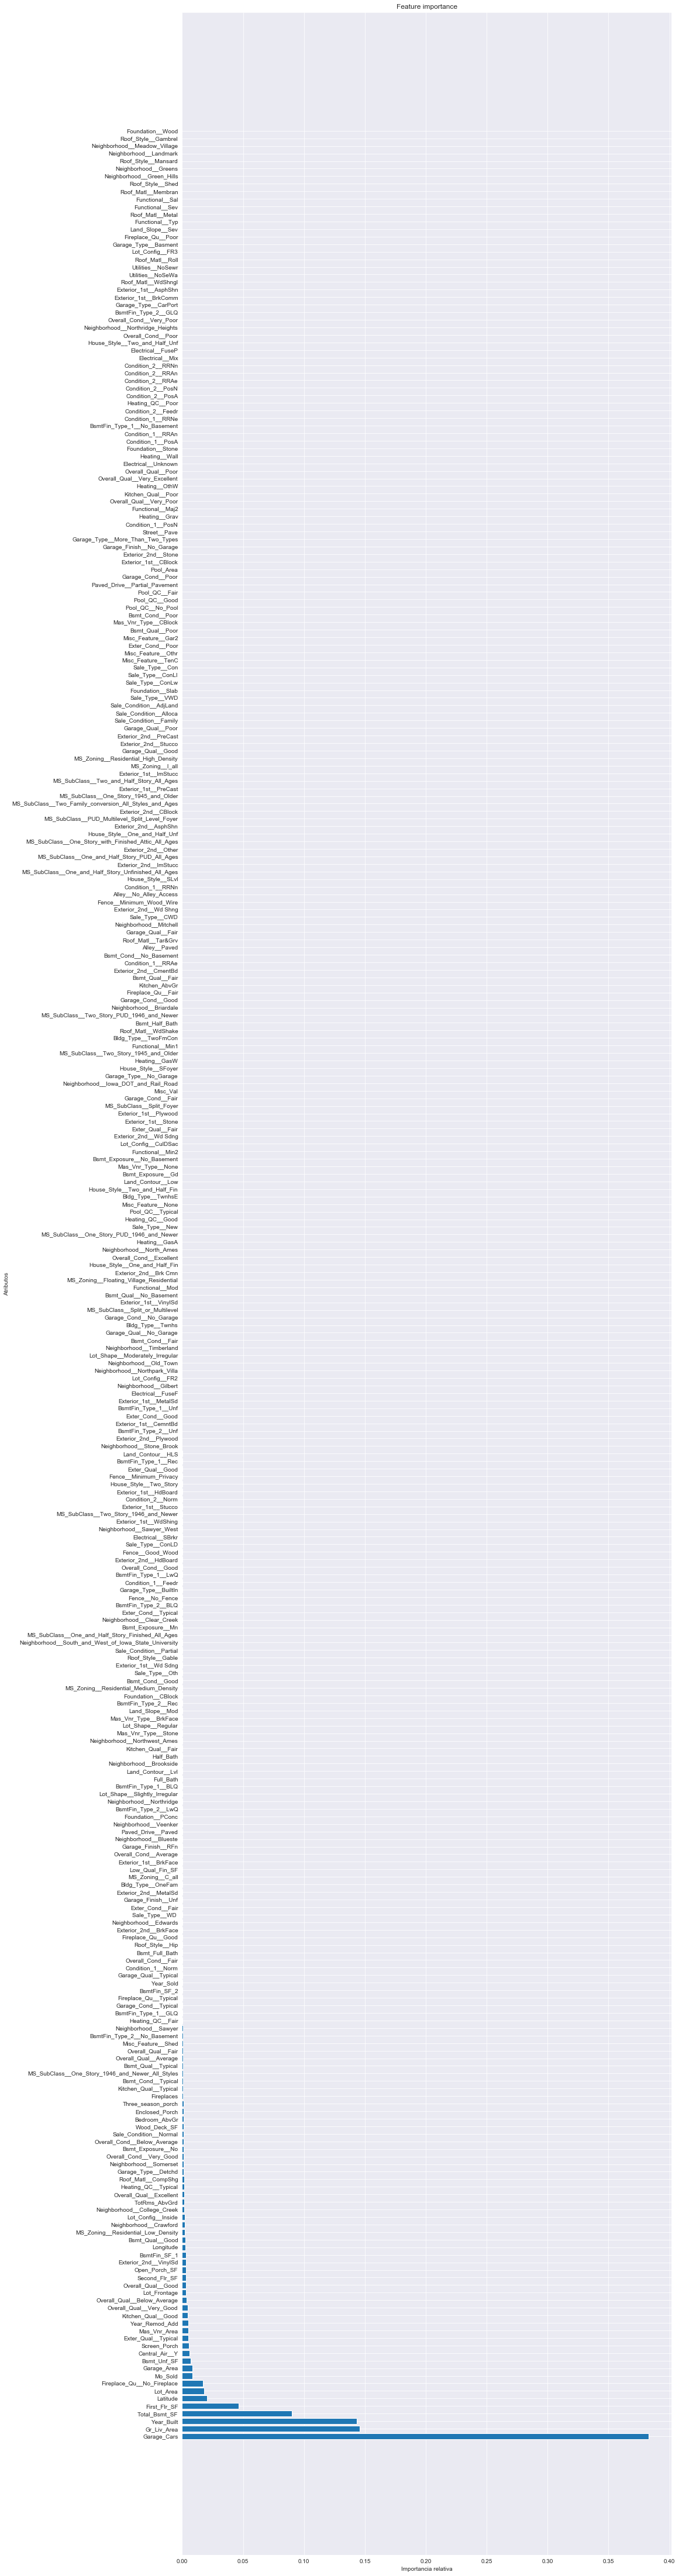

In [53]:
# Gráfica de los atributos 
plt.figure(figsize=(15,80))
afx.plot_importance(reg_tree, variables)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

In [54]:
# Función  para extraer los 10 parametros más importantes y guardarlos en un dataframe

def infer_k_features(df, model, feat_names, k_feats=10):
    """TODO: Docstring for infer_k_features.
    :arg1: TODO
    :returns: TODO
    """
    # preserve temporary copy
    tmp_df = df.copy()
    # infer feature importance score
    tmp_importance = model.feature_importances_
    # sort features
    sort_importance = np.argsort(tmp_importance)[::-1]
    # associate feat names with its relative importance
    names = [feat_names[i] for i in sort_importance]
    #mungle into a dataframe
    tmp_attr = pd.DataFrame(
        {'name': names,
         'score': tmp_importance[sort_importance]}
    )
    # restrict dataframe to k attributes
    tmp_attr = tmp_attr[:k_feats]['name']
    # filter attributes
    tmp_df = tmp_df[
        tmp_df.columns[
            tmp_df.columns.isin(tmp_attr)
        ]
    ]
    return tmp_df

In [18]:
dfbest=infer_k_features(df, reg_tree, variables, k_feats=10)

In [55]:
# añadimos la variable objetivo al dataframe nuevo
dfbest['Sale_Price']= df['Sale_Price']

In [20]:
dfbest.shape

(2930, 11)

#### Ejercicio 5: Refactorización del modelo y pickling
* En función de los atributos seleccionados en el ejercicio anterior, vuelva a generar conjuntos de entrenamiento y validación.
* Dentro de los datos de entrenamiento genere una búsqueda de grila con GridSearchCV utilizando los siguientes hiperparámetros:
    * Máximo de atributos: Evalúe todos los posibles atributos.
    * Máximo de profundidad: entre 1 a 32.
    * Validaciones cruzadas : 5.
* Reporte la mejor combinación de hiperparámetros y su desempeño asociado. Compare el desempeño en la muestra de validación con el modelo por defecto.

#### Pickling
* Ahora generaremos una serialización de nuestro modelo depurado, y nuestros conjuntos de entrenamiento y validación depurados. Para ello importe el módulo pickle.
* pickle contiene la función dump , que permite guardar el modelo desarrollado. La forma canónica para desarrollar el pickling es:

```python  
pickle.dump(<OBJETO_CON_EL_MODELO>, open('nombre-apellido-actividad07.sav','wb'))
```

* Envíe su modelo y conjuntos de entrenamiento a un compañero.

In [21]:
# lista de variables
variables= list(dfbest.columns)
variables.remove('Sale_Price')
variables

['Lot_Area',
 'Year_Built',
 'Total_Bsmt_SF',
 'First_Flr_SF',
 'Gr_Liv_Area',
 'Garage_Cars',
 'Garage_Area',
 'Mo_Sold',
 'Latitude',
 'Fireplace_Qu__No_Fireplace']

In [63]:
# generamos las muestras definiendo la matriz de atributos
dfbest.dropna()
X_train, X_test, y_train, y_test = train_test_split(dfbest.loc[:,variables],
# el vector objetivo
dfbest['Sale_Price'],
# el tamaño de la muestra  a dejar como validación
test_size=.33,
# definiendo la semillapseudoaleatoria
random_state=1986)

In [28]:
# Generación del modelo
%time
reg_tree_grid_cv = GridSearchCV(DecisionTreeRegressor(),
# evaluamos 10 escenarios
{'min_samples_split': np.linspace(0.1, 1.0,10),
# con una profundidad de ramas hasta 32
'max_depth': np.linspace(1, 32, 32),
# evaluando 10 escenarios
'min_samples_leaf': np.linspace(0.1, 0.5,10),
# evaluando todos los atributos en la matriz
'max_features':list(range(1,X_train.shape[1]))},
# Con 5 validaciones cruzadas
cv=5,
# Ocupando todos los núcleos del computador
n_jobs=-1).fit(X_train, y_train)

Wall time: 0 ns


In [30]:
# Extraemos los mejores parametros del modelo
reg_tree_grid_cv.best_params_

{'max_depth': 32.0,
 'max_features': 7,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

In [31]:
#Obtenemos el mejor puntaje de r 2
reg_tree_grid_cv.best_score_

0.6207172128975667

In [33]:
#Métricas de desempeño
print("Test MSE:", mean_squared_error(y_test, reg_tree_grid_cv.predict(X_test)).round(5))
print("Test MAE:", median_absolute_error(y_test, reg_tree_grid_cv.predict(X_test)).round(5))
print("Test R2:", r2_score(y_test, reg_tree_grid_cv.predict(X_test)).round(5))


Test MSE: 2837714738.51825
Test MAE: 23153.89655
Test R2: 0.57166


- Se puede apreciar que éstos modelos tienen un rendimiento inferior al primer modelo, debido quizás a que la cantidad de atributos disminuye considerablemente, el error MAE aumentó  en un 50 % aprox. y el r2 disminuyó  de 0.78 a 0.57.

 

In [64]:
# Reformulación del modelo con los mejores paramétros (Correr de nuevo se desconfigurarón los test)

%time
reg_tree_grid_2 = DecisionTreeRegressor(max_depth= 32, max_features=10)
reg_tree_grid_2.fit(X_train, y_train)

Wall time: 0 ns


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [24]:
# Reporte de valores

print("Test MSE:", mean_squared_error(y_test, reg_tree_grid_2.predict(X_test)).round(5))
print("Test MAE:", median_absolute_error(y_test, reg_tree_grid_2.predict(X_test)).round(5))
print("Test R2:", r2_score(y_test, reg_tree_grid_2.predict(X_test)).round(5))


Test MSE: 1799420021.66494
Test MAE: 17500.0
Test R2: 0.72838


- Se puede apreciar que aumentó el valor del modelo al seleccionar los mejores paramétros de los mejores atributos, sin embargo es un poco inferior que el modelo original con todos los atributos, disminuyó de un r2 de 0,78 a un r2 de 0,73 aún así resulta explicativo el modelo. 

In [25]:
#Predicciones del modelo refactorizado

preds = reg_tree_grid_2.predict(dfbest[variables])
dfbest["preds"] = preds


In [26]:
# Data set con las columnas predichas y el precio real
dfbest[["preds", "Sale_Price"]]



,preds,Sale_Price
0,155000.0,215000
1,105000.0,105000
2,172000.0,172000
3,150000.0,244000
4,189900.0,189900
5,195500.0,195500
6,213500.0,213500
7,187500.0,191500
8,236500.0,236500
9,189000.0,189000


In [27]:
dfbest["percent_error"]=((dfbest["Sale_Price"]- dfbest["preds"])/dfbest["Sale_Price"])*100  



In [28]:
print( "La media del error entre las predicciones y el valor real de Sale Price es: ", abs(round(dfbest["percent_error"].mean(),3)))
print( "La desviación estandar del error entre las predicciones y el valor real de Sale Price es: ", abs(round(dfbest["percent_error"].std(),3)))

La media del error entre las predicciones y el valor real de Sale Price es:  1.465
La desviación estandar del error entre las predicciones y el valor real de Sale Price es:  21.4


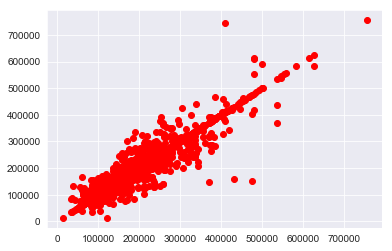

In [102]:
plt.scatter(preds, dfbest["Sale_Price"],color='red')

plt.show()

- Finalmente observamos que las predicciones tienen un error bajo, 1.5 % con respecto al original, esto se aprecia en el gráfico de regresión entre los varlores predichos y los valores de reales del precio de ventas, por lo que el modelo es bastante aceptable.

In [145]:
# Serialización del modelo con Pickle 

pickle.dump(reg_tree_grid_2, open('juan-oyarce-actividad07.sav','wb'))

In [45]:
# Serialización del modelo con Pickle X_train, X_test, y_train, y_test

pickle.dump(X_train, open('X_train.sav','wb'))

In [41]:
# Serialización del modelo con Pickle X_train, X_test, y_train, y_test

pickle.dump(X_test, open('x_test.sav','wb'))

In [42]:
# Serialización del modelo con Pickle X_train, X_test, y_train, y_test

pickle.dump(y_train, open('y_train.sav','wb'))

In [43]:
# Serialización del modelo con Pickle X_train, X_test, y_train, y_test

pickle.dump(y_test, open('y_test.sav','wb'))